# Trabajo de Visión Artificial

## Dataset
[Dataset de señales de tráfico - kaggle](https://www.kaggle.com/datasets/msalman97/dataset-for-traffic-sign-master-app/data)

### Info obtenida del datacard
Este conjunto de datos consiste en más de 60 señales de tráfico. El conjunto fue creado utilizando señales del **German Traffic Sign Recognition Benchmark Dataset**, señales recolectadas localmente, señales de distintos conjuntos de datos y imágenes de señales obtenidas de Internet. Las imágenes fueron aumentadas utilizando un script en Python.

Las imágenes aumentadas se procesaron de la siguiente manera:

**Redimensionamiento:** 32x32, 64x64, 128x128, 256x256

**Reducción de brillo:** -60%

**Aumento de brillo:** +60%

**Desenfoque aplicado a:** imágenes de 128x128, 256x256 y originales

**Niebla añadida a:** imágenes de 128x128, 256x256 y originales

**Alteración de color:** brillo, contraste y color con valores de 1.8

Después de la ampliación, las imágenes se renombran así:
`[00000_00001_00012]`

* `00000` corresponde a la clase

* `00001` corresponde al lote de imágenes de la clase 0 (contiene 29 imágenes); después de 29 imágenes pasará a `[00002]`

* `00012` indica el número de imágenes en una clase

Este conjunto de datos se utiliza para entrenar un modelo **CNN personalizado** para la detección de imágenes e integrar el modelo entrenado en una aplicación móvil desarrollada en **Flutter**.

Dentro de este conjunto de datos también hay una carpeta **Testing**, que se usa para probar y validar el modelo después del entrenamiento. Las imágenes de esta carpeta son nuevas, tomadas y recortadas de Internet.

Si estás siguiendo mi proyecto en GitHub **Traffic-Sign-Master-App** y deseas usar este conjunto de datos en el código original, descárgalo y colócalo dentro de la carpeta **Backend**. Todas las clases de señales están listadas en el archivo **traffic_sign_classes.py**.

Para el reconocimiento en tiempo real de señales de tráfico usando **Yolov5**, he creado un conjunto de datos que contiene imágenes etiquetadas de señales para detección.
**Conjunto de datos Yolo:** [https://www.kaggle.com/datasets/msalman97/signs-dataset-yolov5format](https://www.kaggle.com/datasets/msalman97/signs-dataset-yolov5format)

Si encuentras útil este conjunto de datos, por favor dame crédito visitando mi perfil de GitHub: [https://github.com/salman-97](https://github.com/salman-97). Sígueme para actualizaciones y explora mi repositorio completo para más proyectos y recursos. Tu apoyo significa mucho.


In [129]:
import os
from PIL import Image
from collections import Counter
import pandas as pd 
import os


# Añadiendo basepath > Si se trabaja en colab hay que agregar un directorio
dir_base = "/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset" # Cambiar por la ruta local (Estoy usando WSL y un disco compartido)

def resumen_dataset(dir_base, muestra=5):
    print(">>> Exploración del dataset <<<")
    print("Directorio base:", dir_base)
    print()

    if not os.path.exists(dir_base):
        print("La ruta no existe, revisa el path.")
        return

    dim_cont = Counter()
    res_clase = {}
    directorios = ['Train', 'Test', 'Testing']

    for directorio in directorios:
        dir_path = os.path.join(dir_base, directorio)
        if os.path.isdir(dir_path):
            print(f"\nExplorando directorio: {directorio}")
            cont_imgs = 0
            for root, _, archivos in os.walk(dir_path):
                img_archivos = [f for f in archivos if f.lower().endswith(('.jpg','.jpeg','.png'))]
                cont_imgs += len(img_archivos)
            res_clase[directorio] = cont_imgs
        else:
            print(f"\nDirectorio '{directorio}' no encontrado en la ruta base.")


    # Resumen por directorio
    print("\n>>> Número de imágenes por directorio encontrado <<<")
    for cls, cont in res_clase.items():
        print(f"{cls}: {cont} imágenes")

# Ejecutar resumen 
resumen_dataset(dir_base)

>>> Exploración del dataset <<<
Directorio base: /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset


Explorando directorio: Train

Explorando directorio: Test

Explorando directorio: Testing

>>> Número de imágenes por directorio encontrado <<<
Train: 78532 imágenes
Test: 3625 imágenes
Testing: 139 imágenes


Ahora, veamos solo los elementos del directorio "Train" que tiene clases bien definidas en subdirectorios

In [130]:
def ver_train_clases(dir_path):
   
    if not os.path.isdir(dir_path):
        raise ValueError(f"La dir_path '{dir_path}' no es un directorio válido.")

    subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    conteo = {}

    for subdir in subdirs:
        dir_path_subdir = os.path.join(dir_path, subdir)
        elementos = os.listdir(dir_path_subdir)
        conteo[subdir] = len(elementos)

    print(f"Número total de clases: {len(subdirs)}")
    #return conteo # Si se quiere diccionario
    return pd.DataFrame(list(conteo.items()), columns=['clase', 'instancias'])

ver_train_clases(dir_base+"/Train")


Número total de clases: 63


,clase,instancias
0,0,935
1,1,2858
2,10,2300
3,11,1697
4,12,2390
...,...,...
58,61,919
59,62,1160
60,7,2281
61,8,2135


Número total de clases: 63


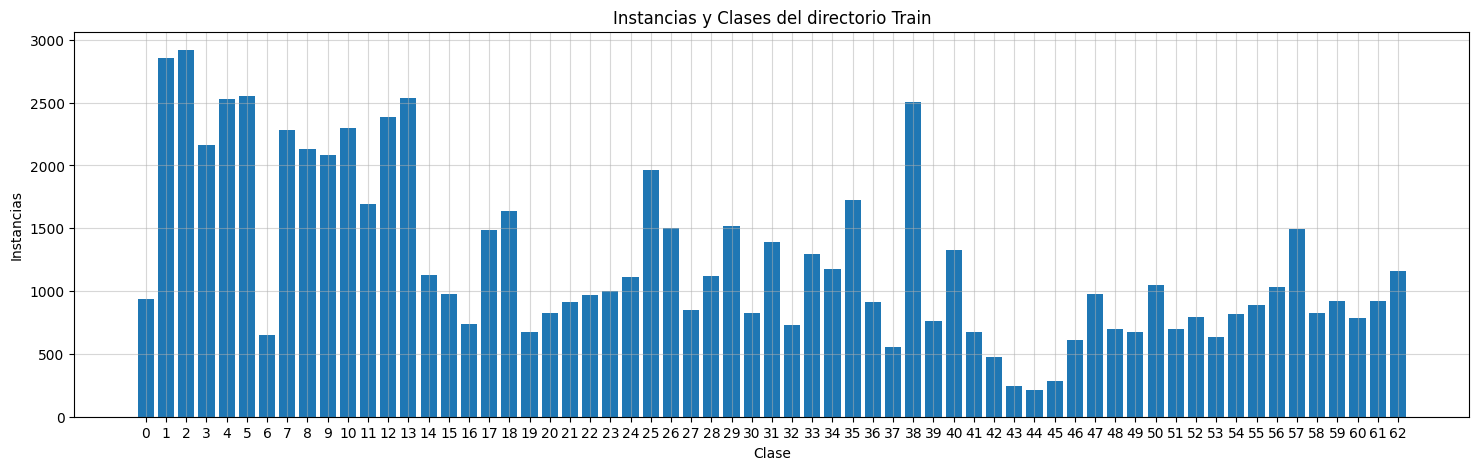

In [131]:
# en forma gráfica
import matplotlib.pyplot as plt
import os

# Guardamos en una variable
clases_train = ver_train_clases(os.path.join(dir_base, "Train"))
clases_train['clase'] = clases_train['clase'].astype('int')
clases_train = clases_train.sort_values(by='clase').reset_index(drop=True)
#Graficamos
plt.figure(figsize=(18,5))
plt.bar(clases_train['clase'].astype(str), clases_train['instancias'])
plt.title("Instancias y Clases del directorio Train")
plt.xlabel("Clase")
plt.ylabel("Instancias")
plt.grid(True, alpha = 0.5)
plt.show()

In [132]:
#Características básicas
print(f"Número mínimo de instancias: {clases_train['instancias'].min()}")
print(f"Perteneciente a la clase: {clases_train['instancias'].idxmin()}")
print(f"Número mínimo de instancias: {clases_train['instancias'].max()}")
print(f"Perteneciente a la clase: {clases_train['instancias'].idxmax()}")

Número mínimo de instancias: 209
Perteneciente a la clase: 44
Número mínimo de instancias: 2919
Perteneciente a la clase: 2


**Existe alto desbalance entre las clases en el directorio de entrenamiento "Train"**

Ahora, enfocándonos en los documentos CSV existentes:

In [133]:
# Leer el CSV de Train para ver detalles
data_train = pd.read_csv(os.path.join(dir_base, "train.csv"))
#Ordenando por clase
data_train = data_train.sort_values(by="ClassId")
data_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
568,105,109,9,10,95,100,0,Train/0/00000_00006_00028.png
569,112,118,10,11,103,108,0,Train/0/00000_00006_00029.png
552,46,49,5,6,41,44,0,Train/0/00000_00006_00012.png
553,48,51,6,6,43,45,0,Train/0/00000_00006_00013.png
554,50,53,5,6,45,48,0,Train/0/00000_00006_00014.png


Al parecer, indica que solo una parte del dataset de entrenamiento está anotado "annotation" -> BoundingBox

In [134]:
# Elementos que tienen BoundingBox
print("Elementos con Annotation:\n", sorted(data_train["ClassId"].unique().tolist()))
print(f"En total son {data_train["ClassId"].unique().shape[0]}/{clases_train['clase'].shape[0]} con Annotation")
print("Elementos sin Annotation:\n", [x for x in clases_train['clase'].tolist() if x not in data_train["ClassId"].tolist()])
print(f"En total son {len([x for x in clases_train['clase'].tolist() if x not in data_train["ClassId"].tolist()])}/{clases_train['clase'].shape[0]} sin Annotation")


Elementos con Annotation:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
En total son 43/63 con Annotation
Elementos sin Annotation:
 [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
En total son 20/63 sin Annotation


In [135]:
# Analizando cúantos elementos tiene cada uno
print("Elementos por clase con Annotation: ")
print(data_train["ClassId"].value_counts().sort_index())

Elementos por clase con Annotation: 
ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64


In [136]:
data_train["ClassId"].value_counts().sort_index()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64

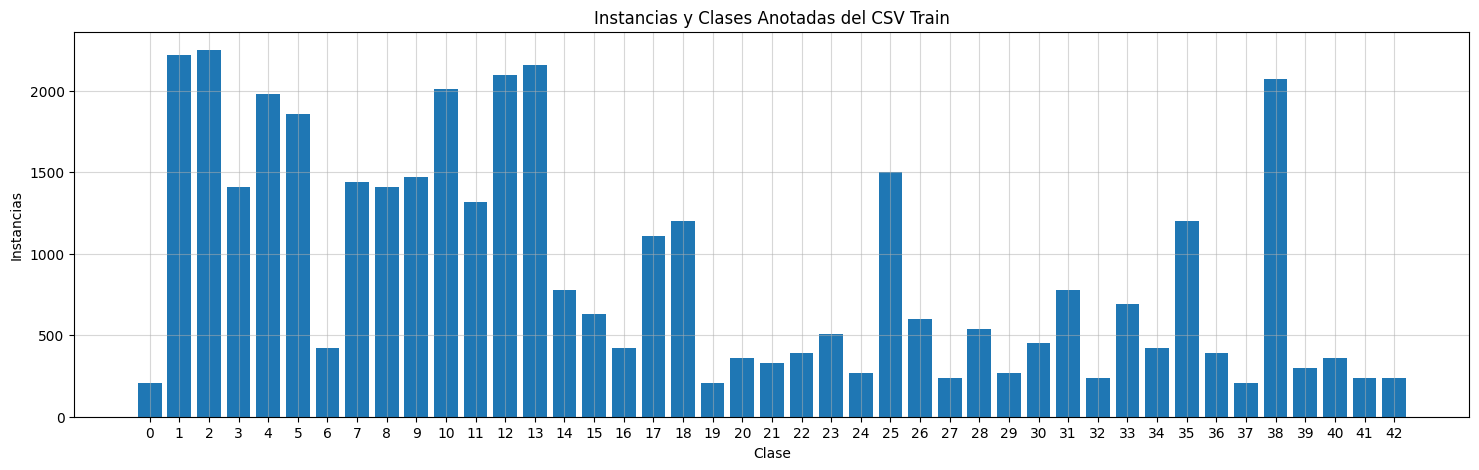

In [137]:

#Graficamos
plt.figure(figsize=(18,5))
plt.bar(data_train["ClassId"].value_counts().sort_index().index.astype(str), data_train["ClassId"].value_counts().sort_index())
plt.title("Instancias y Clases Anotadas del CSV Train")
plt.xlabel("Clase")
plt.ylabel("Instancias")
plt.grid(True, alpha = 0.5)
plt.show()

In [138]:
#elementos máximos y mínimos
#Características básicas
print(f"Número mínimo de instancias: {data_train['ClassId'].value_counts().min()}")
print(f"Perteneciente a la clase: {data_train['ClassId'].value_counts().idxmin()}")
print(f"Número mínimo de instancias: {data_train['ClassId'].value_counts().max()}")
print(f"Perteneciente a la clase: {data_train['ClassId'].value_counts().idxmax()}")

Número mínimo de instancias: 210
Perteneciente a la clase: 0
Número mínimo de instancias: 2250
Perteneciente a la clase: 2


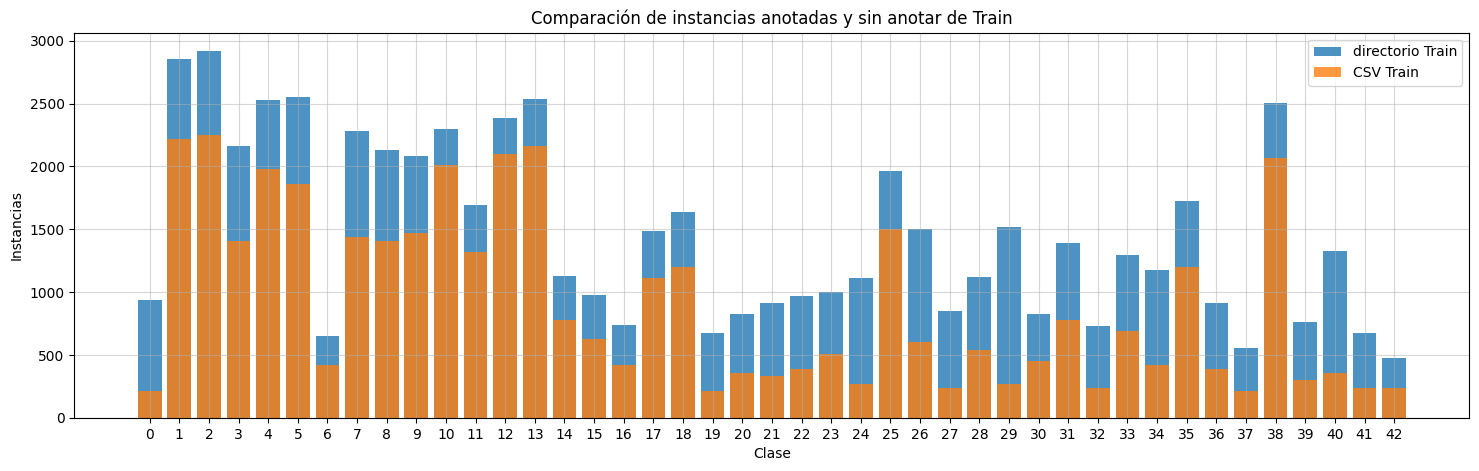

In [139]:

#Graficamos CSV vs Directorio
plt.figure(figsize=(18,5))
plt.bar(clases_train['clase'].iloc[0:43].astype(str), clases_train['instancias'].iloc[0:43], alpha = 0.8, label="directorio Train")
plt.bar(data_train["ClassId"].value_counts().sort_index().index.astype(str), data_train["ClassId"].value_counts().sort_index(), alpha = 0.8, label = "CSV Train")
plt.title("Comparación de instancias anotadas y sin anotar de Train")
plt.xlabel("Clase")
plt.ylabel("Instancias")
plt.legend(loc="upper right")
plt.grid(True, alpha = 0.5)
plt.show()

**Hay imbalance de clases en los datos anotados para el entrenamiento**

## Info encontrada
- En el dataset existen 3 directorios: Train, Test y Testing. Se tiene en cada uno:
    Train: $78532$ imágenes (con $63$ subdirectorios - clases)
    Test: $3625$ imágenes (sin subdirectorios)
    Testing: $139$ imágenes (sin subdirectorios)
- En Train, existen $63$ clases de señales de tránsito, con variabilidad de muestras, desde $209$ hasta $2919$, teniendo valor mínimo y máximo en las clases $44$ y $2$, respectivamente.
- En el CSV de train existen $43$ clases con Annotations con un valor mínimo de instancias de $210$, pertenecientes a la clase $0$.

## Selección de imágenes para trabajar
Usando la info encontrada, vamos a seleccionar un mismo número de imágenes por clase en Train para trabajar

In [140]:
import random

def seleccionar_imagenes_aleatorias(dir_train, num_imagenes_por_clase, semilla=2212):
    """
    Selecciona un número aleatorio de imágenes de cada subdirectorio (clase)
    en el directorio de entrenamiento especificado.

    Args:
        dir_train (str): La ruta al directorio 'Train'.
        num_imagenes_por_clase (int): El número de imágenes a seleccionar de cada clase.
        semilla (int): La semilla para el generador de números aleatorios para reproducibilidad.

    Returns:
        dict: Un diccionario donde las claves son los nombres de las clases (subdirectorios)
              y los valores son listas de rutas a las imágenes seleccionadas.
    """
    random.seed(semilla)
    imagenes_seleccionadas = {}
    
    if not os.path.isdir(dir_train):
        print(f"Error: El directorio '{dir_train}' no existe.")
        return imagenes_seleccionadas

    for clase_dir in sorted(os.listdir(dir_train)):
        path_clase = os.path.join(dir_train, clase_dir)
        
        if os.path.isdir(path_clase):
            archivos_img = [f for f in os.listdir(path_clase) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if len(archivos_img) < num_imagenes_por_clase:
                # Si hay menos imágenes que las solicitadas, se toman todas
                seleccion = archivos_img
            else:
                # Selecciona aleatoriamente el número de imágenes especificado
                seleccion = random.sample(archivos_img, num_imagenes_por_clase)
            
            # Almacena las rutas completas de las imágenes seleccionadas
            imagenes_seleccionadas[clase_dir] = [os.path.join(path_clase, img) for img in seleccion]
            
    return imagenes_seleccionadas

# Seleccionamos 5 imágenes por cada clase del directorio Train
dir_entrenamiento = os.path.join(dir_base, "Train")
muestra_imagenes = seleccionar_imagenes_aleatorias(dir_entrenamiento, num_imagenes_por_clase=5, semilla=2212)
# Habría que cambiar al número mínimo instancias existentes > Revisar Info encontrada

# Imprimir una muestra del resultado para verificar
print(f"Se seleccionaron imágenes de {len(muestra_imagenes)} clases.")
print("Ejemplo para la clase '0':")
for ruta_img in muestra_imagenes.get('0', []):
    print(ruta_img)

print("\nEjemplo para la clase '10':")
for ruta_img in muestra_imagenes.get('10', []):
    print(ruta_img)

Se seleccionaron imágenes de 63 clases.
Ejemplo para la clase '0':
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00017_00016.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00006_00023.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00031_00002.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00006_00026.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00014_00014.png

Ejemplo para la clase '10':
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00037_00020.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00057_00020.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00072_00000.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00004_00020.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00011_00016.png
